#1. Hiperparâmetros, overfit e otimização

O que será visto:

- Definir sobre max_depth

- Definir sobre a árvore de decisão ( DecisionTreeClassifier)

- Mostrar gráficos com o seaborn

- Mostrar gráficos com matplotlib

- Definir hiperparâmetros

##Introdução

Trataremos de otimização de modelos.

Como pré-requisito, você deve ter feito alguns cursos de Machine Learning, como o curso de classificação e o curso de validação cruzada - dois conceitos que utilizaremos na otimização de parâmetros dos nossos estimadores.

Nos outros cursos, nós já estudamos uma árvore de decisão e aprendemos que é possível estabelecer uma profundidade máxima para essa árvore. Por exemplo, uma árvore de decisão padrão do SKLearn pode ter max_depth = 2, ou seja, a árvore fará duas perguntas antes de tomar a decisão de qual classificação será aplicada a determinados dados. Com isso, podemos ter um bom resultado. Se fizermos max_depth = 3, a árvore criada será mais complexa, e podemos ter um resultado ainda melhor.

Isso significa que, antes de treinarmos o modelo, o algoritmo que irá aprender e gerar a árvore de decisão tem um parâmetro - por exemplo, max_depth. A medida que esse parâmetro é fixado, podemos treiná-lo e testá-lo para verificar quão bons são os resultados. Mas se max_depth = 3 é melhor do que max_depth = 2, por que não utilizamos logo max_depth = 10? Ou até mesmo max depth = 64? 

Suponha que estamos tentando resolver um problema de classificação com accuracy. No primeiro teste, com uma árvore de decisão de max_depth = 2, temos um índice de 75% de acerto. Já com max_depth = 3, esse índice sobe para 78%. Como esse número aumentou, uma conclusão lógica seria que, quanto maior o max_depth, melhor será o nosso índice de acerto. Mas será que isso é verdade?

Nesse mesmo problema, utilizamos max_depth = 64 e o resultado foi um índice menor, de 72%. Isso significa que o treino da árvore é claramente influenciado pelo max_depth. Apesar dos treinos cada vez melhores, veremos que, em determinado momento, os testes começam a ficar cada vez piores. Ao longo desse curso aprenderemos sobre um tipo de situação chamada de overfitting: quando o nosso modelo fica "viciado" no treino e ruim para os testes.

Até o momento, estamos explorando um único parâmetro e em uma única dimensão - nesse caso, uma dimensão discreta (1, 2, 3, 4, (...), 64, ou valores até maiores).

Devemos tomar cuidado, pois se cada um dos valores desse hiperparâmetro levar 5 minutos para ser rodado, um hiperparâmetro com 64 parâmetros levará 5 horas e meia para terminar sua execução. Nesses casos, existem várias opções, como paralelizar ou rodar apenas um trecho do hiperparâmetro - e algumas dessas opções nós testaremos aqui, como explorar o grid pedaço por pedaço. É uma estratégia possível, mas que não necessariamente garante que encontraremos o melhor estimador/modelo possível.

Além disso, nesse curso, abordaremos árvores de decisão com mais parâmetros (dois, três e até mesmo quatro). A partir de dois parâmetros (max_depth e min_samples_leaf, por exemplo), será realmente gerado um grid para explorarmos.

Aprendendo a importância de explorar o espaço de parâmetros e como eles podem influenciar a qualidade do nosso modelo de acordo com a métrica escolhida (no nosso exemplo, accuracy, pois estamos trabalhando com classificação padrão), passaremos a usar o próprio SKLearn com GridSearchCV e tirando proveito de validação cruzada. Nós iremos discutir também as limitações do SKLearn (geradas por limites de features ou por features que serão implementadas no futuro).

Com tudo isso, entenderemos como escolher o melhor modelo para nossos dados.

##Entendendo o que é um parâmetro

O projeto que utilizaremos neste curso é uma continuação do projeto no qual trabalhos no curso de validação cruzada (Cross-validation).

Vamos partir do código utilizado naquele curso.

In [ ]:
# Carga dos dados
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

preco  vendido  idade_do_modelo   km_por_ano
0   30941.02        1               18  35085.22134
1   40557.96        1               20  12622.05362
2   89627.50        0               12  11440.79806
3   95276.14        0                3  43167.32682
4  117384.68        1                4  12770.11290

In [ ]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão
# Feito propositalmente para simular uma situação em que a simples técnica de hold out (treino/teste) levaria a resultados ruins.
# E aí isso instigou a necessidade de usarmos validação cruzada.

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

preco  vendido  idade_do_modelo   km_por_ano
4999  74023.29        0               12  24812.80412
5322  84843.49        0               13  23095.63834
5319  83100.27        0               19  36240.72746
5316  87932.13        0               16  32249.56426
5315  77937.01        0               15  28414.50704

In [ ]:
# DummyClassifier para termos um baseline. Queremos ver o quao bom um modelo pode ser, sem eu ter que fazer muita coisa.
# Ele tem por padrão o estratificado: vai considerar a proporção de 0 e 1 (classes) para fazer a predição.
# Então já é um chute razoável: se há muita classe 0, ele vai chutar muito 0.
# E aqui já está atualizado para usar a validação cruzada com o DummyClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [58.00, 58.00]


Vamos agora rodar a mesma coisa com o DecisionTreeClassifier.

Na prática, é possível rodar um algoritmo qualquer como baseline. 

O prof. gosta de rodar um DummyClassifier e um bom algoritmo como o DecisionTreeClassifier pois, se você apenas rodar o bom algoritmo, ele pode não se encaixar bem aos dados e ter um resultado muito ruim, pior até que o DummyClassifier. E aí, você corre o risco de ficar com um baseline muito baixo.

Então, é bacana ter 2 baselines.

In [ ]:
#DecisionTreeClassifier ainda como baseline (comparação com o DummyClassifier)
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [ ]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador
# Objetivo: Avaliar o quão bom o algoritmo será para prever novos modelos de carros. 
# Na prática, o teste do algoritmo será feito com modelos não vistos durante o treinamento.

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

preco  vendido  idade_do_modelo   km_por_ano  modelo
0   30941.02        1               18  35085.22134      18
1   40557.96        1               20  12622.05362      24
2   89627.50        0               12  11440.79806      14
3   95276.14        0                3  43167.32682       6
4  117384.68        1                4  12770.11290       5

In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Na prática, aqui fazemos uma validação cruzada que agrupa pelo modelo do carro.

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [ ]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


Até aqui, foi o que fizemos no curso de validação cruzada.

O próximo passo é: Digamos que eu queira usar o modelo DecisionTreeClassifier.

Vamos entrão trazer o código novamente para darmos sequência.


In [ ]:
#DecisionTreeClassifier
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


Veja que temos a variável modelo:

In [ ]:
modelo

DecisionTreeClassifier(max_depth=2)

Quero agora visualizar essa árvore que foi treinada.

In [ ]:
#Será preciso instalar o graphviz, na versão 0.9 e o pydot
!pip install graphviz==0.9
!pip install pydot

#O graphviz precisa instalar com apt-get
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=["não", "sim"],
                feature_names=features)
graph = graphviz.Source(dot_data)
graph

NotFittedError: ignored

Veja o erro: 'This DecisionTreeClassifier instance is not fitted yet.'

**Cuidado**: Quando fazemos a validação cruzada com cv=10, temos 10 modelos diferentes. Qual dos 10 usaremos?

Não queremos nenhum deles!

Na valição cruzada, treinamos 10 vezes para ter uma estimativa de quão bem o modelo funcionará no mundo real. Agora queremos o modelo de verdade.

Então, agora pegamos o nosso modelo e treinamos 'pra valer' com tudo, ou seja, com todos os nossos dados: nosso x_azar, y_azar. E esperamos um resultado semelhante ao obtido no intervalo da validação cruzada.

Vamos então acrescer ao código o treino do modelo e plotar a árvore.

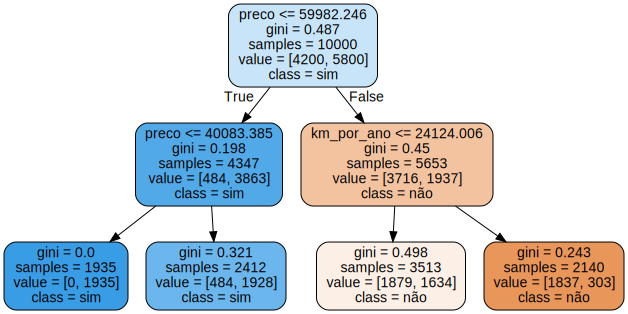

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

#Treinando o modelo
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=["não", "sim"],
                feature_names=features)
graph = graphviz.Source(dot_data)
graph

Veja que a árvore não é muito profunda: Tem apenas 2 decisões (1ª e 2ª camadas).

E se colocássemos 3 níveis de profundidade (max_depth = 3)?

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Na prática, aqui fazemos uma validação cruzada que agrupa pelo modelo do carro.

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


Opa, já melhorou a acurácia média de 75,78% para 78,67%.

Vamos então plotar a árvore novamente:

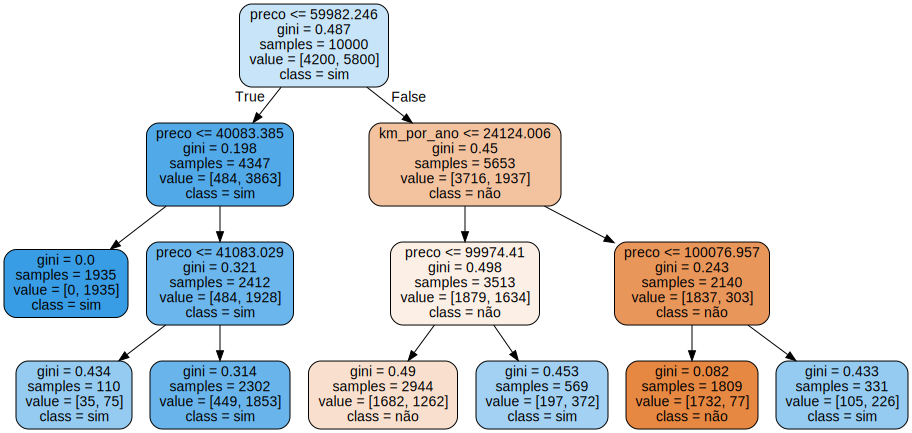

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

#Treinando o modelo
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=["não", "sim"],
                feature_names=features)
graph = graphviz.Source(dot_data)
graph

E aí, se com profundidade 3 foi melhor que 2, tendemos a achar que quanto maior a profundidade (max_depth), melhor.

Vamos então testar com 10.

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
# Na prática, aqui fazemos uma validação cruzada que agrupa pelo modelo do carro.

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=10)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


Veja que o resultado com max_depth = 10 já foi pior (77,19%) do que quando rodamos com max_depth = 3 (78,67%).

Vamos rodar o gráfico, mas veja que fica difícil de interpretar pois nem cabe na tela:

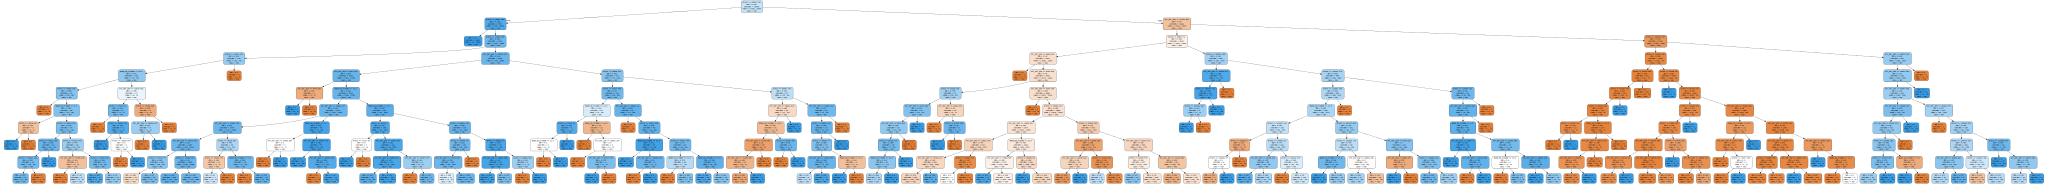

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

#Treinando o modelo
modelo.fit(x_azar, y_azar)
features = x_azar.columns
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True,
                class_names=["não", "sim"],
                feature_names=features)
graph = graphviz.Source(dot_data)
graph

Então veja que não há uma regra para a escolha do max_depth. E a escolha desse número vai influenciar o resultado do modelo.

Os algoritmos tem parâmetros (pode-se consultar na documentação sklearn) e, alterá-los, faz com que tenhamos resultados diferentes.

Veremos na sequência como escolher tais parâmetros de modo a otimizar nosso estimador.

##Quanto mais complexa a árvore, melhor?

Vimos que fornecemos parâmetros para nossos estimadores antes do treino, a exemplo do 'max_depth' no DecisionTreeClassifier. E os chamamos de hiperparâmetros.

Esse hiperparâmetros são diferentes dos parâmetros internos do modelo, que são alterados de acordo com o aprendizado do modelo. (estes não são hiperparâmetros).

E qual valor de hiperparâmetro escolher?

Podemos testar diversos valores!

**Testando parâmetros**

Vamos definir uma função que roda a árvore de decisão para um max_depth específico:

In [ ]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  imprime_resultados(results)

Exemplo de uso da função:

In [ ]:
roda_arvore_de_decisao(10)

Accuracy médio 77.19
Intervalo [75.26, 79.13]


Posso então fazer um loop for para rodar com o range de 'max_depth' do meu interesse:

In [ ]:
for i in range(1,33):
  roda_arvore_de_decisao(i)

Accuracy médio 75.78
Intervalo [73.67, 77.90]
Accuracy médio 75.78
Intervalo [73.67, 77.90]
Accuracy médio 78.67
Intervalo [76.40, 80.94]
Accuracy médio 78.63
Intervalo [76.41, 80.86]
Accuracy médio 78.56
Intervalo [76.42, 80.69]
Accuracy médio 78.12
Intervalo [75.53, 80.72]
Accuracy médio 77.96
Intervalo [75.74, 80.19]
Accuracy médio 77.86
Intervalo [75.81, 79.91]
Accuracy médio 77.38
Intervalo [75.28, 79.48]
Accuracy médio 77.19
Intervalo [75.26, 79.13]
Accuracy médio 76.97
Intervalo [74.71, 79.23]
Accuracy médio 76.49
Intervalo [74.66, 78.33]
Accuracy médio 75.81
Intervalo [73.79, 77.82]
Accuracy médio 75.66
Intervalo [73.64, 77.68]
Accuracy médio 75.16
Intervalo [72.93, 77.38]
Accuracy médio 75.11
Intervalo [73.31, 76.90]
Accuracy médio 74.74
Intervalo [72.48, 76.99]
Accuracy médio 74.33
Intervalo [71.92, 76.74]
Accuracy médio 74.34
Intervalo [72.03, 76.64]
Accuracy médio 74.22
Intervalo [71.83, 76.62]
Accuracy médio 73.80
Intervalo [71.56, 76.05]
Accuracy médio 73.81
Intervalo [71

Fica ruim de analisar tantos resultados. Vamos ajustar a função para imprimir apenas:

- tamanho do max_depth da árvore; e

- a média do test_score.

In [ ]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
  print("Árvore max_depth = %d, media = %.2f" % (max_depth, results['test_score'].mean() * 100))

Refazendo o loop com a função ajustada:

In [ ]:
for i in range(1,33):
  roda_arvore_de_decisao(i)

Árvore max_depth = 1, media = 75.78
Árvore max_depth = 2, media = 75.78
Árvore max_depth = 3, media = 78.67
Árvore max_depth = 4, media = 78.63
Árvore max_depth = 5, media = 78.56
Árvore max_depth = 6, media = 78.12
Árvore max_depth = 7, media = 77.96
Árvore max_depth = 8, media = 77.86
Árvore max_depth = 9, media = 77.38
Árvore max_depth = 10, media = 77.19
Árvore max_depth = 11, media = 76.97
Árvore max_depth = 12, media = 76.49
Árvore max_depth = 13, media = 75.81
Árvore max_depth = 14, media = 75.66
Árvore max_depth = 15, media = 75.16
Árvore max_depth = 16, media = 75.11
Árvore max_depth = 17, media = 74.74
Árvore max_depth = 18, media = 74.33
Árvore max_depth = 19, media = 74.34
Árvore max_depth = 20, media = 74.22
Árvore max_depth = 21, media = 73.80
Árvore max_depth = 22, media = 73.81
Árvore max_depth = 23, media = 73.38
Árvore max_depth = 24, media = 73.43
Árvore max_depth = 25, media = 73.14
Árvore max_depth = 26, media = 73.04
Árvore max_depth = 27, media = 72.91
Árvore max

Note que a partir do 'max_depth' = 3, o resultado foi piorando, o que soa estranho: "Uma árvore simples não pode tomar muita decisão, não tem muita regra!". 

Se pararmos para pensar: Se eu tiver 3 ou 4 regras (max_depth da árvore), só consigo cobrir alguns casos.

E aí, minha intuição me diria que, quanto maior a profundidade da árvore, mais perfeita ela consegue ser treinada. Mais perfeita ficará o treino dela, pois ela é capaz de tomar decisões mais complexas.

E uma árvore com 32 decisões está ficando cada vez mais perfeita em relação aos dados que estamos passando para ela no treino. Ou seja, quanto maior o 'max_depth', a árvore tenderá a ficar especialista e com resultados muito bons na base de treino (dados vistos no treinamento), porém muito ruim em relação aos dados de teste (dados não vistos).

É o que parece estar ocorrendo nos resultados printados acima: Árvore excelente no treino, mas ruim no teste.

Vamos ver se é isso que está ocorrendo.

##Otimizando um hiperparâmetro e o problema do overfit

Para verificarmos os resultados da árvore em relação aos dados de treino e teste, vamos ajustar a função para imprimir também a média do resultado nos dados de treino:

In [ ]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) #Setar True aqui
  print("Árvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, results['train_score'].mean() * 100, results['test_score'].mean() * 100))

Vamos rodar as árvores novamente com a função ajustada:

In [ ]:
for i in range(1,33):
  roda_arvore_de_decisao(i)

Árvore max_depth = 1, treino = 75.79, teste = 75.78
Árvore max_depth = 2, treino = 75.79, teste = 75.78
Árvore max_depth = 3, treino = 78.75, teste = 78.67
Árvore max_depth = 4, treino = 78.79, teste = 78.63
Árvore max_depth = 5, treino = 78.94, teste = 78.56
Árvore max_depth = 6, treino = 79.17, teste = 78.12
Árvore max_depth = 7, treino = 79.50, teste = 77.96
Árvore max_depth = 8, treino = 79.89, teste = 77.86
Árvore max_depth = 9, treino = 80.46, teste = 77.38
Árvore max_depth = 10, treino = 81.16, teste = 77.19
Árvore max_depth = 11, treino = 82.03, teste = 76.97
Árvore max_depth = 12, treino = 82.89, teste = 76.49
Árvore max_depth = 13, treino = 83.95, teste = 75.81
Árvore max_depth = 14, treino = 85.03, teste = 75.66
Árvore max_depth = 15, treino = 86.14, teste = 75.16
Árvore max_depth = 16, treino = 87.19, teste = 75.11
Árvore max_depth = 17, treino = 88.31, teste = 74.74
Árvore max_depth = 18, treino = 89.26, teste = 74.33
Árvore max_depth = 19, treino = 90.32, teste = 74.34
Ár

Bingo! A árvore está ficando cada vez melhor/perfeita para os dados de treino, porém pior em relação aos dados de teste. 

Vamos visualizar eses resultados de um modo melhor, ajustando novamente a função:


In [ ]:
def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) #Setar True aqui
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Árvore max_depth = %d, treino = %.2f, teste = %.2f" % (max_depth, train_score, test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela

Rodando a função novamente, numa estrutura de list_comprehension:

In [ ]:
[roda_arvore_de_decisao(i) for i in range(1,33)]

Árvore max_depth = 1, treino = 75.79, teste = 75.78
Árvore max_depth = 2, treino = 75.79, teste = 75.78
Árvore max_depth = 3, treino = 78.75, teste = 78.67
Árvore max_depth = 4, treino = 78.79, teste = 78.63
Árvore max_depth = 5, treino = 78.94, teste = 78.56
Árvore max_depth = 6, treino = 79.17, teste = 78.12
Árvore max_depth = 7, treino = 79.50, teste = 77.96
Árvore max_depth = 8, treino = 79.89, teste = 77.86
Árvore max_depth = 9, treino = 80.46, teste = 77.38
Árvore max_depth = 10, treino = 81.16, teste = 77.19
Árvore max_depth = 11, treino = 82.03, teste = 76.97
Árvore max_depth = 12, treino = 82.89, teste = 76.49
Árvore max_depth = 13, treino = 83.95, teste = 75.81
Árvore max_depth = 14, treino = 85.03, teste = 75.66
Árvore max_depth = 15, treino = 86.14, teste = 75.16
Árvore max_depth = 16, treino = 87.19, teste = 75.11
Árvore max_depth = 17, treino = 88.31, teste = 74.74
Árvore max_depth = 18, treino = 89.26, teste = 74.33
Árvore max_depth = 19, treino = 90.32, teste = 74.34
Ár

[[1, 75.79116856866345, 75.78421883757397],
 [2, 75.79116856866345, 75.78421883757397],
 [3, 78.75099279906651, 78.67263337284332],
 [4, 78.78762769262194, 78.63280264599946],
 [5, 78.9410073693779, 78.55591244881775],
 [6, 79.17011453793069, 78.12326641953089],
 [7, 79.49680619886925, 77.96318477047309],
 [8, 79.8878103533372, 77.85795103730995],
 [9, 80.45900912486006, 77.3769561546462],
 [10, 81.15899430522666, 77.19420355606299],
 [11, 82.0324897748914, 76.97155235848373],
 [12, 82.89479711407509, 76.49439895201009],
 [13, 83.94708663888434, 75.80733123067736],
 [14, 85.0296638417324, 75.66048240262317],
 [15, 86.14300852294707, 75.15633049496758],
 [16, 87.19199906684938, 75.10782992856304],
 [17, 88.30979402742274, 74.73565827883768],
 [18, 89.25870628782606, 74.33375452328517],
 [19, 90.32425183685724, 74.33789590095503],
 [20, 91.32108470047993, 74.223477897303],
 [21, 92.13877325024768, 73.80182272660134],
 [22, 93.01867719757558, 73.81181823864084],
 [23, 93.7956313685999, 73

VAmos inserir os resultados da função (tabela) em uma variável e depois em um dataframe:

In [ ]:
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth", "train", "test"])
resultados.head()

Árvore max_depth = 1, treino = 75.79, teste = 75.78
Árvore max_depth = 2, treino = 75.79, teste = 75.78
Árvore max_depth = 3, treino = 78.75, teste = 78.67
Árvore max_depth = 4, treino = 78.79, teste = 78.63
Árvore max_depth = 5, treino = 78.94, teste = 78.56
Árvore max_depth = 6, treino = 79.17, teste = 78.12
Árvore max_depth = 7, treino = 79.50, teste = 77.96
Árvore max_depth = 8, treino = 79.89, teste = 77.86
Árvore max_depth = 9, treino = 80.46, teste = 77.38
Árvore max_depth = 10, treino = 81.16, teste = 77.19
Árvore max_depth = 11, treino = 82.03, teste = 76.97
Árvore max_depth = 12, treino = 82.89, teste = 76.49
Árvore max_depth = 13, treino = 83.95, teste = 75.81
Árvore max_depth = 14, treino = 85.03, teste = 75.66
Árvore max_depth = 15, treino = 86.14, teste = 75.16
Árvore max_depth = 16, treino = 87.19, teste = 75.11
Árvore max_depth = 17, treino = 88.31, teste = 74.74
Árvore max_depth = 18, treino = 89.26, teste = 74.33
Árvore max_depth = 19, treino = 90.32, teste = 74.34
Ár

max_depth      train       test
0          1  75.791169  75.784219
1          2  75.791169  75.784219
2          3  78.750993  78.672633
3          4  78.787628  78.632803
4          5  78.941007  78.555912

Como temos uma tabela do pandas, podemos trabalhar com gráfico.

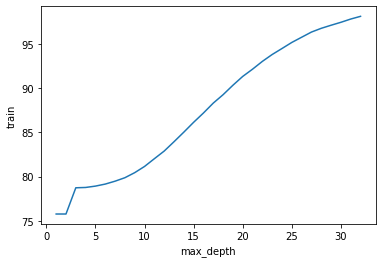

In [ ]:
import seaborn as sns
#imprime um plot de linha cujos dados são os resultados
#No eixo x, quero o max_depth
#No eixo y, quero o treino
sns.lineplot(x = "max_depth", y = "train", data = resultados)
#OBS.: A versão do seaborn que tem o lineplot é a versão 0.9.0 em diante. Caso não plote, pode dar o comando:
#!pip install seaborn==0.9.0
#Caso necessite da instalação, será necessária restartar o kernel do python no Colab.

O gráfico mostra o que tinhamos notado na tabela: O resultado de treino ficando perfeito à medida que o max_depth aumenta.

Vamos plotar também o resultado de teste:

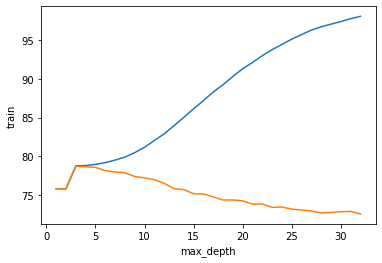

In [ ]:
sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)

Veja que o resultado com os dados de treino contiuou a subir em determinado momento, ao passo que o resultado com os dados de teste começaram a cair.

Tivemos aí o **overfit**: Perfeito para o treino e ruim para o teste.

Por completude, vamos plotar a legenda com o matplotlib:

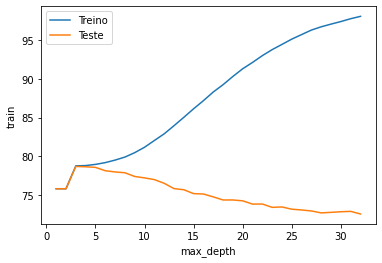

In [ ]:
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y = "train", data = resultados)
sns.lineplot(x = "max_depth", y = "test", data = resultados)
plt.legend(["Treino", "Teste" ])

Agora que varremos o espaço do max_depth de 1 a 32, podemos dar uma olhada ordenando pela qualidade do teste (linha laranja do gráfico), de modo decrescente. Vejamos os 5 primeiros:

In [ ]:
resultados.sort_values("test", ascending=False).head()

max_depth      train       test
2          3  78.750993  78.672633
3          4  78.787628  78.632803
4          5  78.941007  78.555912
5          6  79.170115  78.123266
6          7  79.496806  77.963185

Essas foram as melhores árvores. Usaríamos, por exemplo, a árvore de max_depth = 3.

Veremos mais variações e como tomar essa decisão.

##Revisando a exploração de um espaço de parâmetros

Até aqui vimos o hiperparâmetro "max_depth", que é a profundidade máxima da árvore de decisão, e testamos com diversos valores.

Vimos que poderíamos poderíamos pegar um intervalo, o qual chamaremos de **espaço**. Um espaço, por exemplo, de 1 a 64 é discreto, ou seja, é 1, 2 , 3... 64.

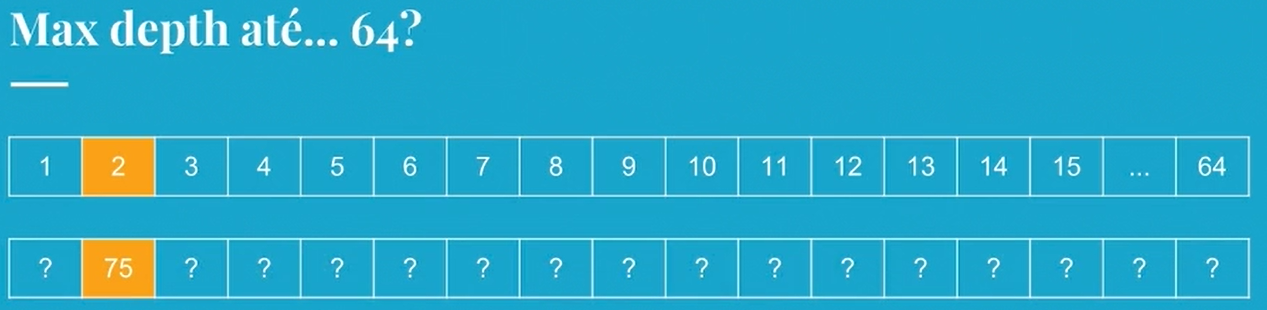

E testamos alguns valores, descobrindo que...

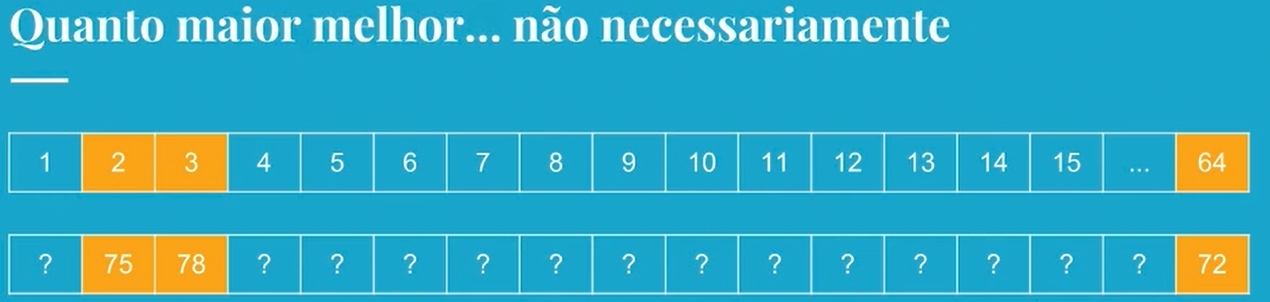




Nos nossos testes tivemos um crescimento, depois apenas queda. Mas poderíamos ter subida, queda, subida, queda... não é possível saber como o modelo vai se comportar em todas os tipos de dados que você fornecer para o espaço do parâmetro.

Então, o que poderíamos fazer? Roda tudo?

No nosso caso fomos até o max_depth=32 mas poderíamos ter ido até o 64. Mas imagina que o tivéssemos um algoritmo mais lento para treinar que o DecisionTreeClassifier, usando validação cruzada, utilizando grupos, levasse 5 minutos para cada max_depth?

Para rodar as 64 vezes, demoraria 5h30m para ver qual dos 64 foi melhor. Aí já começa a complicar!

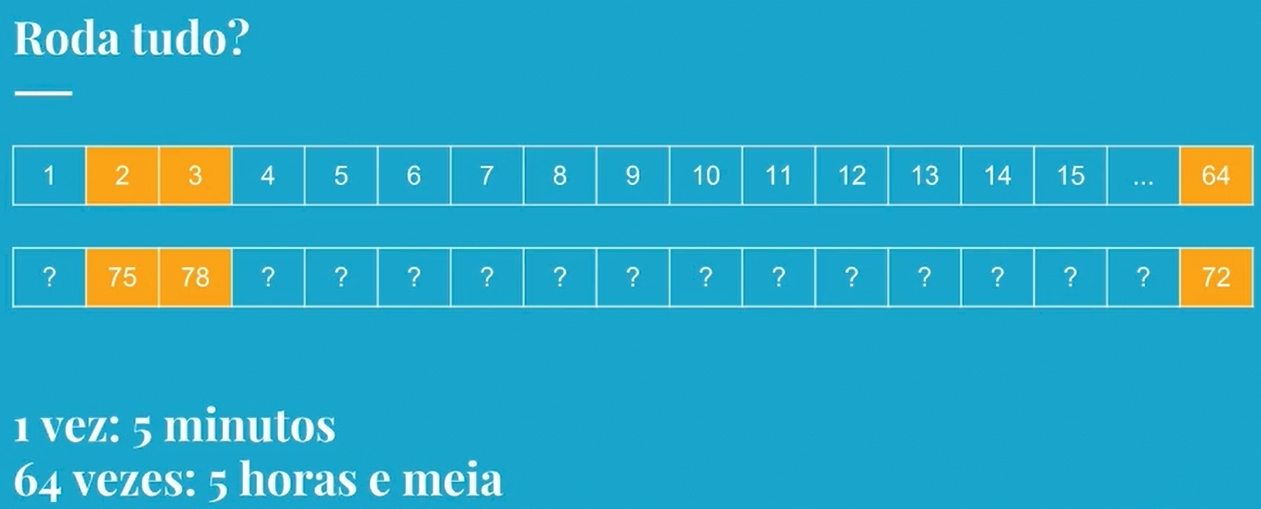


Então, se seu treino e teste é rápido, maravilha! Pode até explorar um espaço maior. Caso contrário, vai demorar demais.

Claro! Existem processos nos quais se pode distribuir, rodar em paralelo, rodar em cloud, etc. Mas não é o momento agora.

Nosso momento é o de entender o que é o espaço de parâmetro, e como otimizá-lo. Vamos pensar em como otimizar não só o algoritmo, mas também o tempo de busca dos melhores parâmetros nesse espaço, não necessariamente distribuindo em várias máquinas.

Vamos otimizar de outras maneiras durante o curso. Há várias de 'otimizar o processo de otimização'. Veremos uma delas aqui. 

Portanto, uma técnica é pegar o parâmetro e varrer o espaço de busca. Mas tem suas desvantagens.

Vamos explorar mais a fundo agora.

#2. Explorando 2 dimensões de hiperparâmetros

O que será visto:

- Definir os elementos mínimos em uma árvore de decisão

- Utilizar o min_samples_leaf para treino

- O que é corr do pandas

##Espaço de parâmetros de duas dimensões

Podemos explorar o espaço do nossos parâmetros, por exemplo,do parâmetro 'max_depth'. E comentamos que podem ser muito lento devido ao nº de variações nos parâmetros.

Olhando para a documentação do DecisionTreeClassifier, vemos que há diversos hiperparâmetros, como o 'min_samples_leaf', que é o nº mínimo de elementos numa folha.

Vamos ver a imagem e comentar para entender o 'min_samples_leaf':

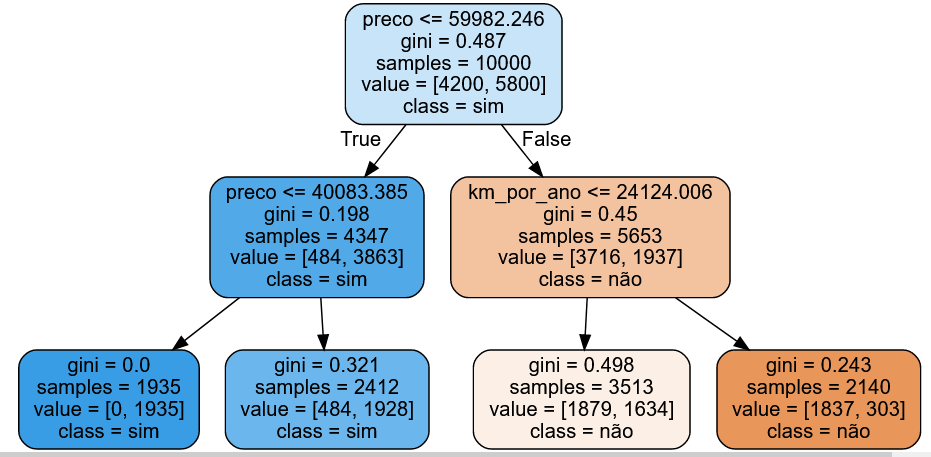

No início, vemos que a árvore começou com 10.000 elementos. A partir daí, quebrou em 4.347 elementos (azul) e 5.653 elementos (bege).

Dos 4.347 elementos azuis, quebrou para 1.935 e 2.412. Esse é o nó final, a folha, que é o último nó de uma árvore. Então a folha azul da esquerda tem 1.935 elementos.

Uma árvore que seria muito 'perfeitinha' seria aquela em que o nº de elementos da folha fosse 1, já que ela teria uma classificação bem específica representando justamente o dado: "Se for exatamente esse elemento a classificação é tal, se for exatamente este outro, a classificação é outra."

Mas não quero que o 'samples' da folha seja 1, porque se o modelo gerasse uma árvore em que o nº de samples é igual a 1, seria um caso muito específico, que provavelmente não vai dar para generalizar.

Então não quero que o mínimo de samples que apareça em cada um dos meus nós (min_samples_leaf) seja muito baixo, pois vou particularizar demais para os dados de treino e não conseguirei generalizar pro mundo real.

Assim, quero configurar o mínimo de samples para o minha folha, e fazemos isso pelo hiperparâmetro 'min_samples_leaf'. Há também outros hiperparâmetros nesse algoritmo.







Famos do 'max_depth' de 1 a 64, mas também podemos falar do 'min_samples_leaf' de 1 a 64.

Ou seja, quero explorar a combinação dos dois espaços de parâmetros:

Na prática, teremos 64 x 64 testes para fazer: 4.096.

Se cada teste durar 5 minutos, levaremos 14 dias rodando.

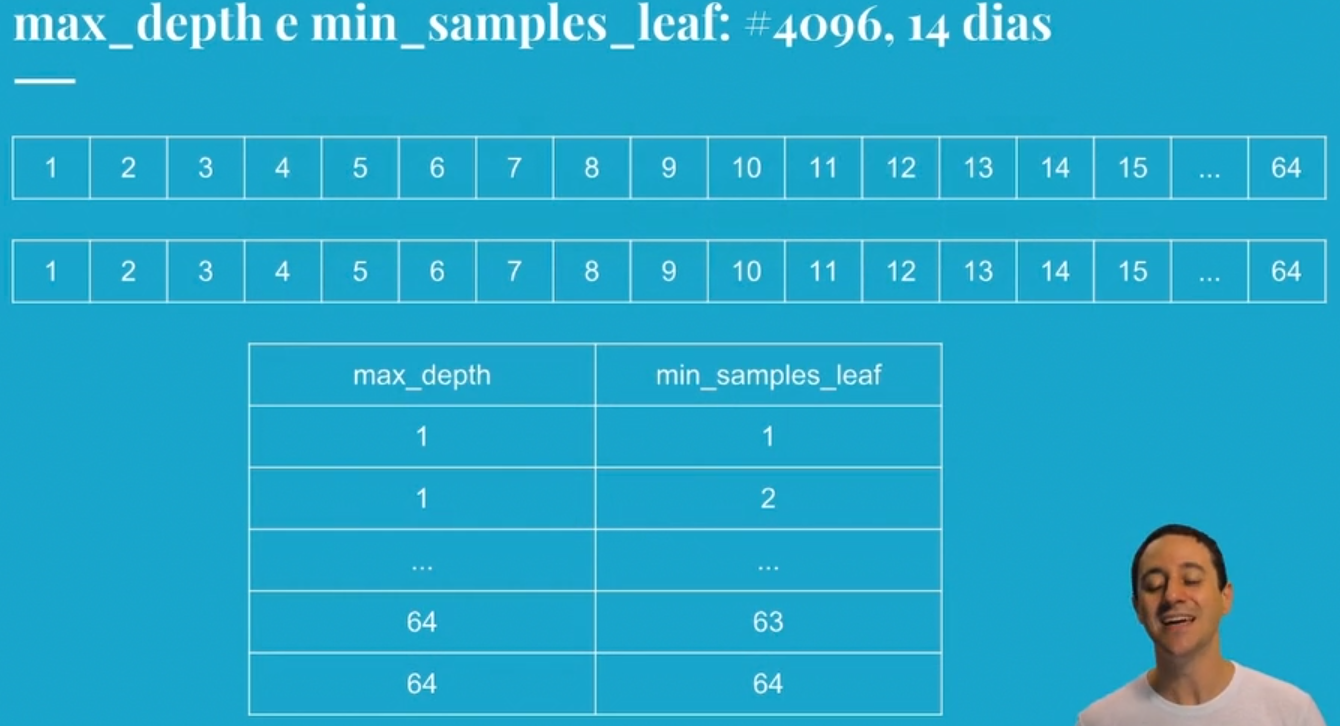

Então, fica complicado fazer a exploração dessa maneira.

Com 2 parâmetros, seria como fazer a busca em um espaço como o abaixo:

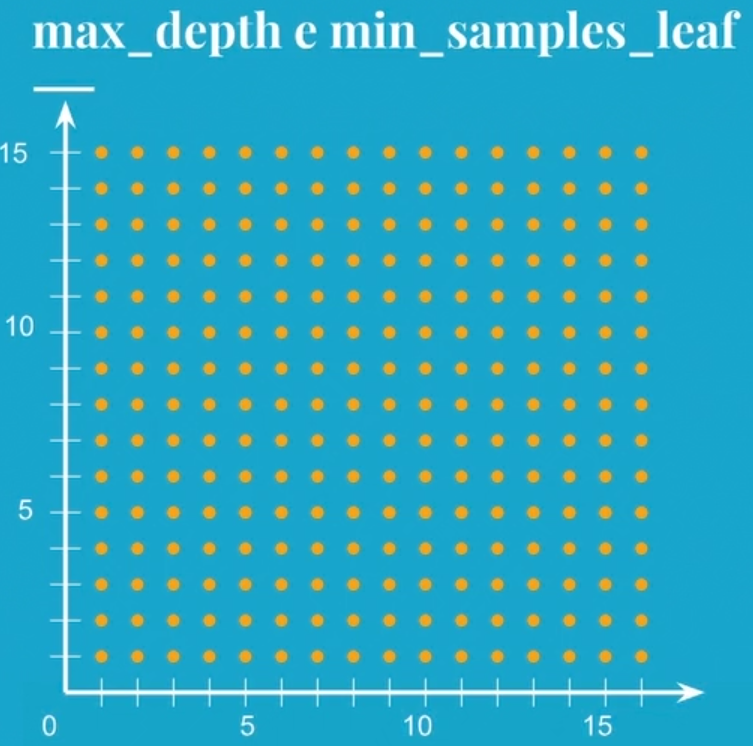

Caso sejam mais de 2 parâmetros, não dá pra visualizar. Falaremos mais a frente.

##Explorando hiperparâmetros de mais dimensões

Vamos fazer funcionar com os 2 parâmetros.

Em vez de rodarmos minha árvore de decisão para os 2 parâmetros: 'max_depth' e 'min_samples_leaf'.

Vamos então ajustar a função:

In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) #Setar True aqui
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  print("Árvore max_depth = %d, min_samples_leaf = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

Ajustando também a forma de rodar os testes e coletar os resultados. Em vez de list comprehension usado antes, vamos fazer um 'for'. Mas para não ficar 'solto', vamos definir uma função:

In [ ]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in range(1,33):
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

Aplicando a função seria assim:

In [ ]:
resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 1, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 2, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 3, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 4, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 5, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 6, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 7, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 8, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 9, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 10, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 11, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 12, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 13, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_

KeyboardInterrupt: ignored

Interrompemos o processo pois demoraria razoavelmente. 

Em vez de explorarmos por completo o espaço de busca, vamos rodar um conjunto menor para fins didáticos. Rodaremos com 4 valores de min_samples_leaf, totalizando então 128 testes (32 x 4).

Vamos então ajustar a função:

In [ ]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

Rodando os testes com a função:

In [ ]:
resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 32, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 64, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 3, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 64, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Árvore max_depth = 4, min_samples_leaf = 32, treino = 78.75, teste = 78.67
Árvore max_depth = 

max_depth  min_samples_leaf      train       test
0          1                32  75.791169  75.784219
1          1                64  75.791169  75.784219
2          1               128  75.791169  75.784219
3          1               256  75.791169  75.784219
4          2                32  75.791169  75.784219

Ao mesmo tempo que há o problema no tempo de treinamento, queremos explorar o espaço de busca dos hiperparâmetros.

Então, precisamos encontrar um modo melhor para fazer isso.

Antes, vamos ver o resultado dos melhores:

In [ ]:
resultados.sort_values("test", ascending=False).head()

max_depth  min_samples_leaf      train       test
15          4               256  78.750993  78.672633
12          4                32  78.750993  78.672633
14          4               128  78.750993  78.672633
13          4                64  78.750993  78.672633
8           3                32  78.750993  78.672633

O melhor max_depth foi 4 e o min_samples_leaf tanto faz: todos tiveram o mesmo resultado.

Agora que temos o resultado de 2 hiperparâmetros, vamos explorar melhor esses dados. 

##Matriz de correlação e explorando mais e mais espaços de parâmetros


A tabela de resultados acima indica a situação de 2 parâmetros ('max_depth' e 'min_samples_leaf') e o quão bem um modelo foi no treino e no teste.

Perguntas possíveis:

- Será que quanto maior a profundidade melhor (max_depth)?

- Será que quanto maior o mínimo de samples em um nó (min_samples_leaf), melhor?

E poderíamos ter vários outros parâmetros e querer saber se quanto maior melhor, menor pior, etc...

Como estão se comportando os valores de treino e teste, em função dos valores dos parâmetros?

Fica difícil ver na tabela. Além disse, olhando, por exemplo, o 'min_samples_leaf', será que o valor de 56 (não testado) teria sido melhor? E o valor de 300?

Portanto, diversos valores não foram testados!

Como testar tudo consome muito processamento, uma das abordagens seria paralelizar, mas claramente é a mais complexa no sentido de horizontalizar em várias máquinas, etc.

Há então a possibilidae de escolher um espaço, como fizemos: testamos 32 valores para max_depth e 4 para min_samples_leaf.

Mas ainda fica a dúvida: Será que há outro espaço que poderia ter sido testado? Teria resultados melhores ou piores?

**Uma maneira de tentarmos visualizar isso (mas não é garantia!) é procurarmos uma relação entre o resultado de treino ou de teste (no nosso caso queremos o de teste) para com os parâmetros. Podemos fazer uma análise de correlação!**

No pandas já conseguimos obtê-la:

In [ ]:
resultados.corr()

max_depth  min_samples_leaf     train      test
max_depth         1.000000e+00     -2.780775e-16  0.536705 -0.027675
min_samples_leaf -2.780775e-16      1.000000e+00 -0.409676  0.349011
train             5.367048e-01     -4.096762e-01  1.000000  0.116466
test             -2.767507e-02      3.490111e-01  0.116466  1.000000

Quanto maior a correlação, mais os 2 valores crescem juntos!

Exemplo olhando pra tabela: 

- Quando o max_depth cresce, o max_depth cresce de igual modo (Claro!).

- Quando o max_depth cresce, o treino parece crescer também. 0.536 significa que está crescendo junto.

- Por outro lado, quando o min_samples_leaf cresce, o treino cai (-0,409). Estão em sentidos opostos.

- Quando o max_depth sobe, o teste meio que está caindo (-0,027), mas nem tanto.

- À medida que o min_samples_leaf sobe, o teste sobe (0,349).

Cuidado: Isso não é uma causalidade!

Seria difícil de visualizar essa tabela com muitos parâmetros. Podemos plotar num gráfico heatmap com o seaborn:

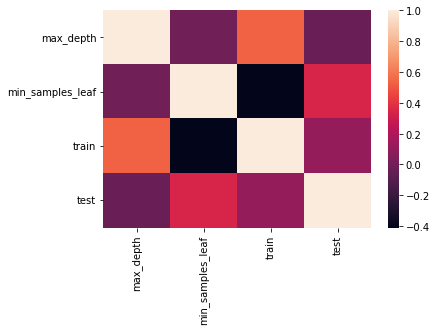

In [ ]:
corr = resultados.corr()
sns.heatmap(corr)

Interpretando o gráfico: Quando a cor é mais clara, indica que a correlação é muito alta! E quando é muito escura, é o inverso: correlação negativa!

Mas essas cores não estão muito bacanas.

Além do heatmap, há outras formas de visualizar.

O próprio pandas consegue comparar todos esses valores através de uma matriz, que mostra os pontos soltos:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb4a7fc9090>,
      dtype=object)

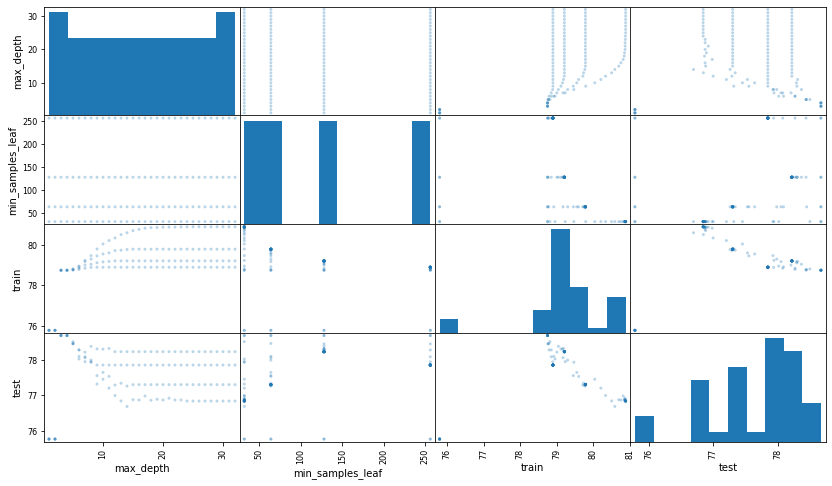

In [ ]:
#Scatter_Matrix Pandas
pd.plotting.scatter_matrix(resultados, figsize = (14, 8), alpha = 0.3) #alpha é a cor

Interpretando o pandas scatter_matrix:

Na diagonal:

- Na diagonal mostra o histograma dos valores. Então note que para o 'min_samples_leaf' testamos valores em 4 intervalos, meio que na mesma quantidade (mesma altura das barras).

- No train, tivemos diversos resultados na faixa de 79%.

- No test, tivemos diversos resultados no valor de 78%.

E o que não é diagonal é equivalente à nossa correlação:

- À medida que o max_depth aumenta, o test vai caindo.

- À medida que o max_depth aumenta, o treino vai subindo.

- Ou seja, vai ficando ruim pro teste e perfeito pro treino.

Então, também dá para ir visualizando as correlações.

Porém, por mais que seja uma forma, analisar várias variáveis em par é meio complicado.

O seaborn também tem algo parecido com o pandas scatter_matrix:

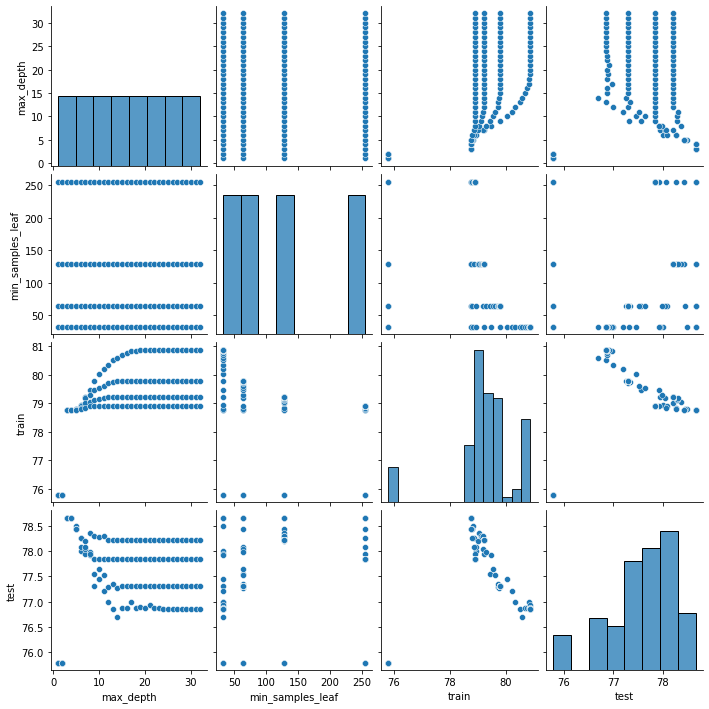

In [ ]:
sns.pairplot(resultados)

Note que o que consigo visualizar aqui é meio assim: 'Olha, não há uma regra geral de quanto maior melhor, ou algo do gênero.

Há um outro gráfico mais bonito que é o seaborn correlation.

https://seaborn.pydata.org/examples/many_pairwise_correlations.html

Vamos ver na documentação e copiar o código de lá para ajustarmos:

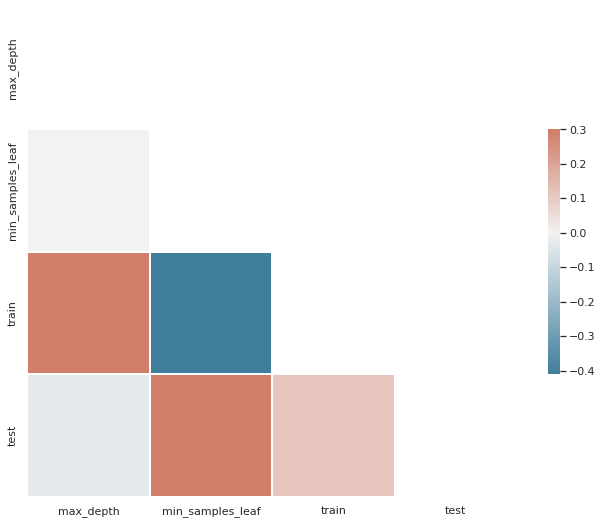

In [ ]:
#Seaborn Correlation

#from string import ascii_letters
#import numpy as np
#import pandas as pd
#import seaborn as sns
#import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset (REMOVER POIS NÃO PRECISAMOS GERAR OS DADOS. JÁ TEMOS!)
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix (REMOVER POIS NÃO JÁ TEMOS A VARIÁVEL 'CORR'!)
#corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Essa matriz já cortou pra gente a metade que não é interessante, pois é equivalente. Só verei o que me interessa.

Interpretando o gráfico:

- O min_samples_leaf parece estar correlacionado com o test. Ou seja, quando maior o min_samples_leaf, maior a qualidade do nosso teste.

Então, o que posso fazer agora?

Veja que antes havíamos testado para 4 valores: 32, 64, 128 e 256.

Assim, em vez de testar todos os valores do min_samples_leaf (ou seja, um espaço de busca gigante, o grid inteiro, que pode ser infinito), já posso rodar com alguns outros valores maiores, já que a análise de correlação nos deu esse indicativo.

Então, vamos, por exemplo alterar o min_samples_leaf:

- DE: 32, 64, 128 e 256.

- PARA: 128, 192, 256 e 512.

Com isso, passo a explorar um pedaço mais específico do grid, indo mais a fundo num pedaço específico para ver se há algo mais interessante.

Isso não garante que vou achar o melhor de todos os resultados. Mas é uma maneira de ir explorando os resultados. 

Vamos rodar então com os novos valores de min_samples_leaf:

In [ ]:
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [128, 192, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "train", "test"])
  return resultados

resultados = busca()
resultados.head()

Árvore max_depth = 1, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 1, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 128, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 192, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 256, treino = 75.79, teste = 75.78
Árvore max_depth = 2, min_samples_leaf = 512, treino = 75.79, teste = 75.78
Árvore max_depth = 3, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 192, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 256, treino = 78.75, teste = 78.67
Árvore max_depth = 3, min_samples_leaf = 512, treino = 77.53, teste = 77.50
Árvore max_depth = 4, min_samples_leaf = 128, treino = 78.75, teste = 78.67
Árvore max_d

max_depth  min_samples_leaf      train       test
0          1               128  75.791169  75.784219
1          1               192  75.791169  75.784219
2          1               256  75.791169  75.784219
3          1               512  75.791169  75.784219
4          2               128  75.791169  75.784219

Agora, vamos gerar a matriz de correlação e o gráfico:

In [ ]:
corr = resultados.corr()

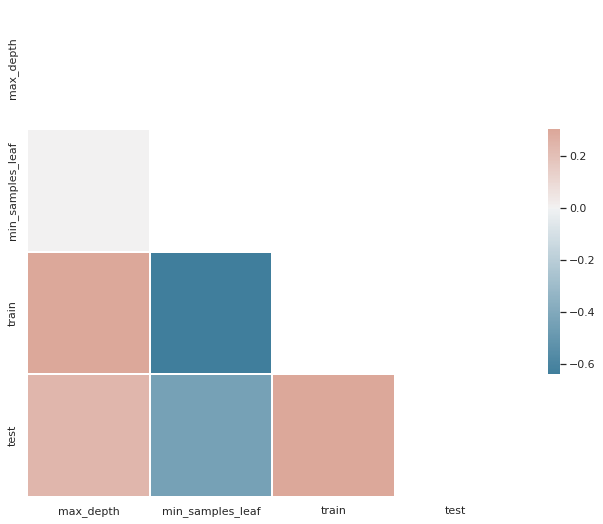

In [ ]:
#Seaborn Correlation

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Opa, agora o gráfico mostrou uma correlação negativa entre min_samples_leaf e o test: À medida que aumentou min_samples_leaf, caiu o teste.

Vamos ver os 5 melhores resultados:

In [ ]:
resultados.sort_values("test", ascending=False).head()

max_depth  min_samples_leaf      train       test
13          4               192  78.750993  78.672633
8           3               128  78.750993  78.672633
9           3               192  78.750993  78.672633
10          3               256  78.750993  78.672633
14          4               256  78.750993  78.672633

Novamente o melhor foi com max_depth = 4, mas foi o min_samples_leaf = 192.

Claro, poderíamos ter explorado outros valores e achado outros resultados. Como disse, não há garantia que obterá O MELHOR valor, mas é uma forma de explorar pedaços do grid (espaço de busca), visando tentar encontrar o valor dos parâmetros que melhoram nosso algoritmo.

Mas até aqui fizemos a análise para 2 parâmetros do DecisionTreeClassifier. Vamos analisar a documentação na sequência e pensar. 

#3. Trabalhando com 3 ou mais dimensões

O que será visto:

- Utilizar mais do que um hiperparâmetro

- Gerar um gráfico com matplotlib

- O que é min_samples_split

Nas aulas anteriores, exploramos um espaço de 2 dimensões, atrelado a 2 parâmetros. Mesmo assim, não exploramos todo o espaço de parâmetros, e mesmo que tenhamos encontrado valores que parecem razoáveis, não temos garantia de que são os melhores possíveis.

Na documentação do DecisionTreeClassifier, encontramos diversos outros parâmetros - e vários deles são hiperparâmetros. 

OBS.: Existem outros tipo de árvores como floresta aleatória, que usarão outros tipos de hiperparâmetros.

Dessa vez, vamos trabalharemos com min_samples_split. Antes, estávamos explorando o mínimo de samples em um nó final (a nossa "folha"), e agora exploraremos o mínimo de "quebras" (splits) que podemos ter no meio da árvore.

Ou seja, qual o mínimo de samples que precisamos ter, para poder fazer um split?

Para isso, na nossa função busca(), precisaremos criar mais um for (agora serão 3 for), novamente com valores fixos - nesse caso, 32, 64, 128 e 256. Além disso, min_samples_split deve ser adicionado:

- como parâmetro da função roda_arvore_de_decisao()

- como parâmetro de DecisionTreeClassifier()

- como um dos valores de tabela

- como uma das colunas de DataFrame()

Vamos aproveitar e incluir, na função:

- o tempo de cada treinamento ('fit_time')

- o tempo para dar as notas ('score_time').

E aí, posso decidir algo do tipo: Por mais que os 2 entreguem um mesmo resultado no teste, 1 deles é mais rápido que o outro. Então esse é o que escolho.

In [ ]:
#Acrescendo o min_samples_split e os tempos de treino (fit_time) e atribuição de notas (score_time)
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True) #Setar True aqui
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100
  #Pode descomentar se quiser: usada apenas para debug. Para muitos treinamentos, printa coisa demais na tela.
  #print("Árvore max_depth = %d, min_samples_leaf = %d, min_samples_split = %d, treino = %.2f, teste = %.2f" % (max_depth, min_samples_leaf, min_samples_split, train_score, test_score))
  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

In [ ]:
#Acrescendo o min_samples_split
def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
      for min_samples_split in [32, 64, 128, 256]:
        tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
        resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns = ["max_depth", "min_samples_leaf", "min_samples_split", "train", "test", "fit_time", "score_time"])
  return resultados

Agora vamos rodar os testes com os 3 hiperparâmetros: max_depth, min_samples_leaf e min_samples_split.

Lembrando, são 3 for:

 - 32 x 4 x 4 = 512 combinações diferentes de parâmetros a testar no cross_validate, que fará 10 tentativas de treino e teste.
 
 - Então, são 512 x 10 = 5.120 splits de treino/teste para rodar. (Demora mesmo!)

In [ ]:
resultados = busca()
resultados.head()

max_depth  min_samples_leaf  min_samples_split      train       test  \
0          1                32                 32  75.791169  75.784219   
1          1                32                 64  75.791169  75.784219   
2          1                32                128  75.791169  75.784219   
3          1                32                256  75.791169  75.784219   
4          1                64                 32  75.791169  75.784219   

   fit_time  score_time  
0  0.005762    0.001682  
1  0.005322    0.001605  
2  0.005286    0.001532  
3  0.005181    0.001477  
4  0.005526    0.001820

OBS.: Repare que removemos o trecho no qual os resultados eram imprimidos na tela. Isso porque, além de aumentar o tempo de execução do nosso código - que já é 4 vezes maior que quando tínhamos apenas 2 parâmetros -, a lista de resultados não nos trazia nenhuma informação relevante, já que era praticamente ilegível, servindo apenas para acompanharmos o *debug*.

Vamos então analisar os resultados, obtendo a correlação no gráfico de matriz de correlação diagonal.

In [ ]:
corr = resultados.corr()

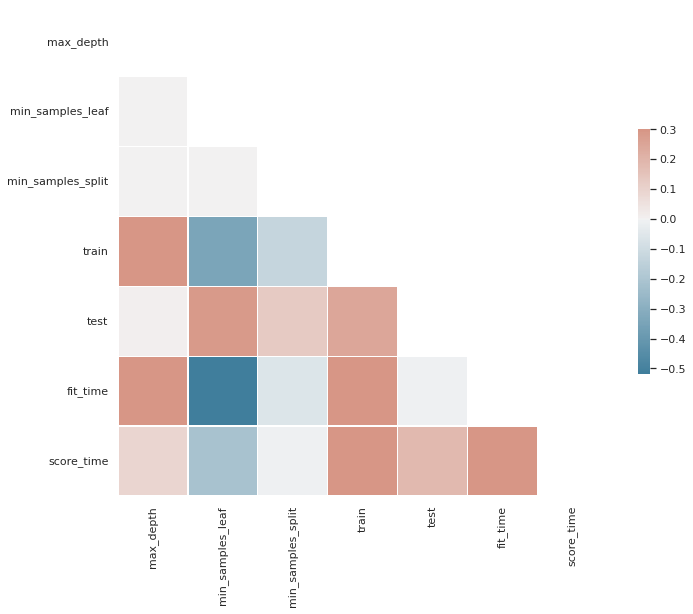

In [ ]:
#Seaborn Correlation

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

5 melhores resultados:

In [ ]:
resultados.sort_values("test", ascending=False).head()

max_depth  min_samples_leaf  min_samples_split      train       test  \
63          4               256                256  78.750993  78.672633   
48          4                32                 32  78.750993  78.672633   
34          3                32                128  78.750993  78.672633   
35          3                32                256  78.750993  78.672633   
36          3                64                 32  78.750993  78.672633   

    fit_time  score_time  
63  0.011189    0.001602  
48  0.011905    0.001703  
34  0.010323    0.001799  
35  0.010062    0.001629  
36  0.009965    0.001737

Vamos analisar então a correlação entre os hiperparâmetros e os resultados de treino e teste, para tomar uma decisão sobre continuar explorando esse espaço ou não.

NOVAMENTE: NADA GARANTE A CERTEZA DE ASSERTIVAS DO TIPO 'QUANTO MAIOR, MELHOR'.

Vamos lá:

Quanto ao tempo de treino, note que é muito rápido: cerca de 0.01 segundos para treinar. É um algoritmo rápido e não há diferenças relevantes entre os tempos em cada tomada. Mas se fosse um algoritmo com tempos grandes de fit_time e score_alto, aí vale a pena escolher uma ou outra combinação de parâmetro que seja mais rápida.

Portanto, fit_time e score_time também retornadas pelo cross_validate para nos auxiliar nessa escolha. Acaba sendo importante para tomada de decisão.

Vimos até agora 3 parâmetros, mas há mais na árvore de decisão.

Portanto, há vários parâmetros e não precisam ser discretos, podendo ser contínuos (0.1; 0.001, etc) ou até uma escala, na qual você quer olhar mais à esquerda ou à direita, por ser uma escala logarítmica ou exponencial (então é mais importante entrar em detalhes mais próximo de valores altos ou baixos.

Enfim, há diversos tipos de espaços que você pode querer explorar:

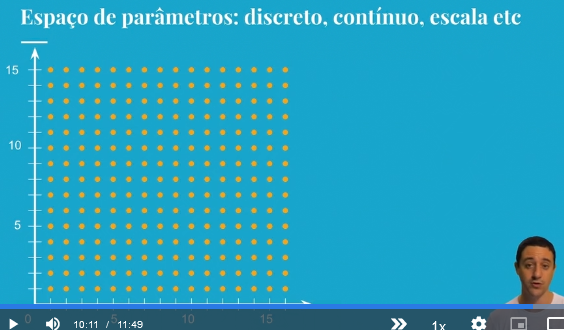

Então, as possibilidades são muitas.

E como é algo comum num processo de otimização de um estimador/modelo, temos uma biblioteca que faz isso pra nós. O sklearn já tem uma maneira de buscar otimização de parâmetros num grid, explorando em várias combinações possíveis.

Veremos na sequência.

#4. Busca de parâmetros com o GridSearchCV

O que será visto:

- Utilizar o GridSearchCV

- Utilizar o accuracy_score

##Usando o GridSearchCV

Agora que já aprendemos a importância de uma busca em grid pelos parâmetros que maximizam a métrica que estamos utilizando no nosso sistema, queremos utilizar uma ferramenta que nos ajude nesse processo.

O próprio SKLearn possui o ***GridSearchCV*** (grid search cross validation), que faz justamente essa busca de hiperparâmetros com validação cruzada.

Para isso, importaremos o *GridSearchCV* do *sklearn.model_selection*. Em seguida, determinaremos o *SEED* como *301* (mantendo o mesmo seed padrão) e definiremos o nosso *espaco_de_parametros*.

Ele deve conter diversas dimensões:

- *max_depth* com os valores 3 e 5

- *min_samples_split* com os valores 32, 64 e 128

- *min_samples_leaf* também com os valores 32, 64 e 128

- *criterion* com os valores *gini* e *entropy* (que são strings)

Ou seja, estaremos explorando 4 dimensões diferentes que resultam em 36 combinações. Nossa busca será um *GridSearchCV()*, passando *DecisionTreeClassifier()*, *espaco_de_parametros* e o cross validation com 10 splits (*cv = GroupKFold(n_split = 10)*).

O *GridSearchCV()* vai funcionar como um modelo. Portanto, podemos fazer *busca.fit()*, que irá rodar o cross validation dentro dele. Portanto, passaremos os parâmetros *x_azar* e *y_azar*, e os grupos (*groups = dados.modelo*).

Depois da busca, passaremos para o nosso *pd.DataFrame()* o *cv_results_*, um dicionário do *GridSearchCV* que pode ser importado em dataframe do Pandas. Por mim, escreveremos *resultados.head()* para recebermos os 5 melhores resultados.

In [ ]:
from sklearn.model_selection import GridSearchCV

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = GroupKFold(n_splits = 10))

#O GridSearchCV funciona como se fosse um modelo. Faz um fit
busca.fit(x_azar, y_azar,groups = dados.modelo)
#Joga os resultados do GridSearch (dicionário retornado no cv_results_) num dataframe pandas
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.014004      0.002333         0.002626        0.000130   
1       0.012769      0.000869         0.002610        0.000083   
2       0.012604      0.000444         0.002503        0.000176   
3       0.012697      0.000370         0.002481        0.000183   
4       0.014525      0.005125         0.002547        0.000069   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               3                     32   
1            gini               3                     32   
2            gini               3                     32   
3            gini               3                     64   
4            gini               3                     64   

  param_min_samples_split                                             params  \
0                      32  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
1                      64  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
2                     128  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
3                      32  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
4                      64  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   

   split0_test_score  ...  split3_test_score  split4_test_score  \
0           0.804757  ...            0.78408           0.783181   
1           0.804757  ...            0.78408           0.783181   
2           0.804757  ...            0.78408           0.783181   
3           0.804757  ...            0.78408           0.783181   
4           0.804757  ...            0.78408           0.783181   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
0           0.797809           0.762866           0.781818            0.77551   
1           0.797809           0.762866           0.781818            0.77551   
2           0.797809           0.762866           0.781818            0.77551   
3           0.797809           0.762866           0.781818            0.77551   
4           0.797809           0.762866           0.781818            0.77551   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
0           0.790262         0.786726        0.011361                1  
1           0.790262         0.786726        0.011361                1  
2           0.790262         0.786726        0.011361                1  
3           0.790262         0.786726        0.011361                1  
4           0.790262         0.786726        0.011361                1  

[5 rows x 22 columns]

Essa tabela nos mostra diversas informações, como a média do tempo de treino, a média do tempo de teste, a acurácia do teste e do treino e o ranking delas, quais foram cada um dos parâmetros utilizados, entre outras.

Com *busca.best_params_*, podemos imprimir na tela os melhores parâmetros; e com *busca.best_score_* * 100, o melhor resultado em porcentagem:

In [ ]:
print(busca.best_params_)
print(busca.best_score_ * 100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


Se quisermos o melhor estimador em si, podemos pegá-lo com *busca.best_estimator_*:

In [ ]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

OBS.: Lembre-se de que existem outro hiperparâmetros que poderíamos tentar otimizar também.

Se quiséssemos, também poderíamos rodar a correlação e montar um gráfico em cima desses dados.

Dado esse resultado, quão bem ele se sairia no mundo real? No curso anterior, aprendemos que, depois que treinamos o estimador com cross validation, podemos rodar um *fit* para obtermos o modelo que utilizaremos no mundo real. Como já temos esse modelo, podemos tentar predizer a sua acurácia com *melhor.predict(x_azar)*, que atribuiremos a uma variável *predicoes*.

Em seguida, criaremos uma variável *accuracy* recebendo *accuracy_score(predicoes, y_azar) * 100*. Lembre-se de importar essa função de *sklearn.metrics*, do contrário ela não funcionará. 

In [ ]:
from sklearn.metrics import accuracy_score 

#EVITAR ESSA ABORDAGEM, POIS ESTARÁ SENDO OTIMISTA (vide tópico seguinte)
predicoes = melhor.predict(x_azar) 
accuracy = accuracy_score(predicoes, y_azar) * 100

print("Accuracy para os dados foi %.2f%%" % accuracy)

Accuracy para os dados foi 78.75%


Accuracy para os dados foi 78.75%.

Mas será que esse é mesmo o resultado que esperamos no mundo real? Veremos!

#5. Nested cross validation e validando o modelo escolhido

O que será visto:

- O que é nested cross validation

- Importar o GroupKFold

- Visualizar o melhor estimador

##Nested cross validation e validando o modelo escolhido

Utilizamos o GridSearchCV do SKLearn para encontrarmos o melhor conjunto de hiperparâmetros em um espaço definido, de modo a otimizar a nossa métrica (accuracy). Quando tentamos analisar quão bem nosso algoritmo se sairia no mundo real, pegamos o melhor conjunto (representado por melhor) e utilizamos um predict() em cima de x_azar - ou seja, com todos os dados e uma única vez. Porém, durante o nosso processo de aprendizado, utilizamos o cross validation, e existem alguns cuidados que devemos tomar a esse respeito.

Na documentação do SKLearn, encontramos uma seção sobre nested versus non-nested cross-validation. O texto afirma que quando estamos utilizando hiperparâmetros, fazendo, por exemplo, o GridSearchCV junto com o cross_validation_score, não devemos descobrir a nossa métrica por meio do predict(), mas sim com outro cross_valiation_score.

Utilizar o predict() acaba sendo muito otimista, pois acabamos incorrendo em um vício sobre os dados que já tínhamos visto. Portanto, essa abordagem deve ser evitada.

**Como ter uma estimativa sem esse vício nos dados que eu já vi?**

No caso de cross validation com busca de hiper parâmetros, fazemos uma nova validação cruzada. Chama-se nested cross validation.

No nosso novo teste, importaremos cross_val_score de sklearn.model_selection. Em seguida, chamaremos cross_val_score(), passando busca, x_azar e y_azar. O cross validation será o mesmo que estávamos utilizando anteriormente (GroupKFold(n_splits=10), e os grupos serão dados.modelo.

Esse código nos retornará vários scores.

In [60]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups = dados.modelo)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 891, in fit
    self._run_search(evaluate_candidates)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py", line 1392, in _run_search
    evaluate_candidates(ParameterGrid(self.param_grid))
  File "/

Veja que deu erro: "The 'groups' parameter should not be None."

É como se não tivéssemos passado nada pros grupos. Se olhar no código acima, verá que sim, passamos 'groups = dados.modelo".

Mas de alguma maneira, esses grupos não estão chegando no GroupKFold. Essa é a verdade, não estão chegando.

A otimização de hiperparâmetros tem um bug mesmo, que ainda está aberto:

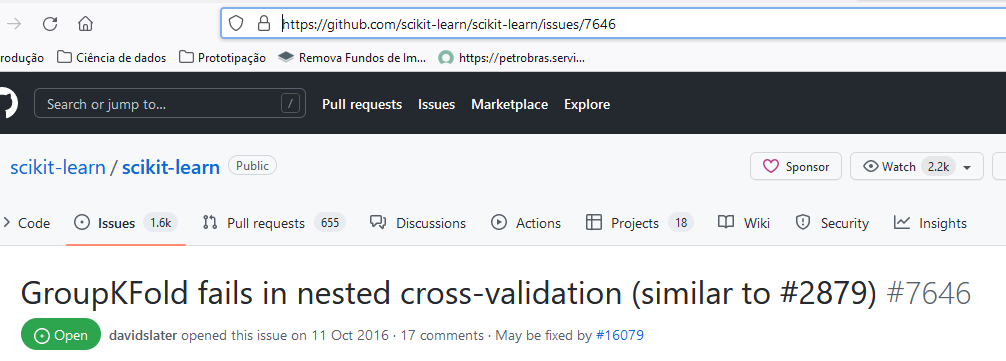

https://github.com/scikit-learn/scikit-learn/issues/7646


É um bug antigo, desde 2016, e a maneira 'educada' de corrigi-lo é razoavelmente complicada para implementar. É possível até acompanhar a discussão no link, etc.

Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection.

Além disso, mudaremos o número de splits para 5, adicionaremos o parâmetro shuffle=True e removeremos o parâmetro groups de busca.fit().

Como estamos rodando com KFold normal, essa estimativa é feita sem saber se o grupo é novo ou não.

Veja que deu erro: "The 'groups' parameter should not be None."

É como se não tivéssemos passado nada pros grupos. Se olhar no código acima, verá que sim, passamos 'groups = dados.modelo".

Mas de alguma maneira, esses grupos não estão chegando no GroupKFold. Essa é a verdade, não estão chegando.

A otimização de hiperparâmetros tem um bug mesmo, que ainda está aberto:

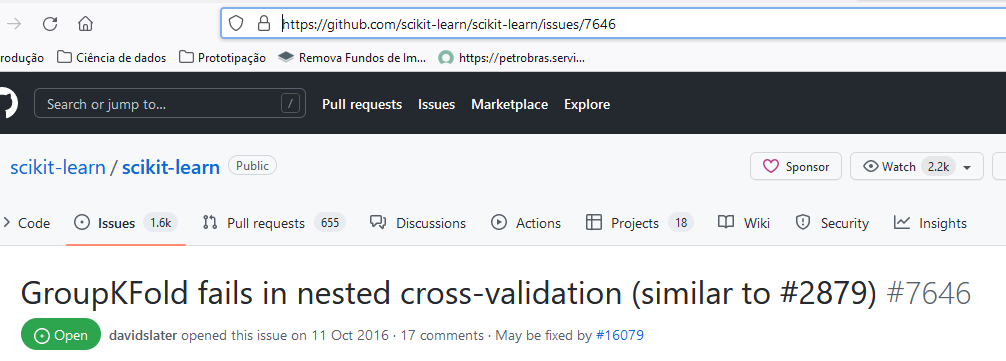

https://github.com/scikit-learn/scikit-learn/issues/7646


É um bug antigo, desde 2016, e a maneira 'educada' de corrigi-lo é razoavelmente complicada para implementar. É possível até acompanhar a discussão no link, etc.






Como o Pandas não suporta nested validation com o GroupKFold, não conseguiremos prever o resultado para novos grupos. Como alternativa, usaremos o KFold comum, que precisa ser importado de sklearn.model_selection.

Além disso, mudaremos o número de splits para 5, adicionaremos o parâmetro shuffle=True e removeremos o parâmetro groups de busca.fit().

Como estamos rodando com KFold normal, essa estimativa é feita sem saber se o grupo é novo ou não.

In [61]:
from sklearn.model_selection import GridSearchCV, KFold

SEED=301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth" : [3, 5],
    "min_samples_split": [32, 64, 128],
    "min_samples_leaf": [32, 64, 128],
    "criterion": ["gini", "entropy"]

}

busca = GridSearchCV(DecisionTreeClassifier(),
                    espaco_de_parametros,
                    cv = KFold(n_splits = 5, shuffle=True))

busca.fit(x_azar, y_azar)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.009205      0.000515         0.001765        0.000295   
1       0.008793      0.000179         0.001517        0.000104   
2       0.008759      0.000116         0.001454        0.000095   
3       0.008776      0.000124         0.001522        0.000154   
4       0.009166      0.000792         0.001713        0.000275   

  param_criterion param_max_depth param_min_samples_leaf  \
0            gini               3                     32   
1            gini               3                     32   
2            gini               3                     32   
3            gini               3                     64   
4            gini               3                     64   

  param_min_samples_split                                             params  \
0                      32  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
1                      64  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
2                     128  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
3                      32  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   
4                      64  {'criterion': 'gini', 'max_depth': 3, 'min_sam...   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0              0.784              0.776             0.8025              0.793   
1              0.784              0.776             0.8025              0.793   
2              0.784              0.776             0.8025              0.793   
3              0.784              0.776             0.8025              0.793   
4              0.784              0.776             0.8025              0.793   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
0             0.7795            0.787        0.009618                1  
1             0.7795            0.787        0.009618                1  
2             0.7795            0.787        0.009618                1  
3             0.7795            0.787        0.009618                1  
4             0.7795            0.787        0.009618                1

Agora podemos rodar o cross_val_score() como gostaríamos, passando KFold(n_splits=5, shuffle=True) no cross validation.

In [62]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=5, shuffle=True))
scores

array([0.7895, 0.7825, 0.7905, 0.7715, 0.7995])

Com eles, é possível reconstruir a média e o intervalo. Para isso, criaremos uma função imprime_scores() que recebe scores. Na media, usaremos scores.mean() * 100, e no desvio scores.std() * 100. 

In [63]:
def imprime_score(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

Em seguida, basta chamarmos a função imprime_score(scores). O resultado será:

In [64]:
imprime_score(scores)

Accuracy médio 78.67
Intervalo [76.80, 80.54]


Para identificar os melhores hiperparâmetros, faço um busca.best_estimator_:

In [65]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(max_depth=3, min_samples_leaf=32, min_samples_split=32)

Agora vamos imprimir a árvore de decisão que encontramos como nosso melhor estimador:

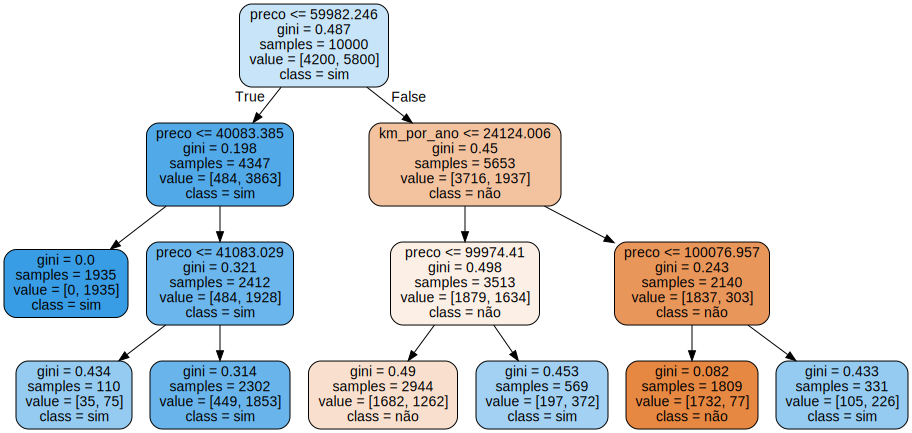

In [66]:
from sklearn.tree import export_graphviz
import graphviz


features = x_azar.columns
#Note que passamos agora o melhor modelo, que foi salvo na variável 'melhor' no passo anterior
dot_data = export_graphviz(melhor, out_file=None, filled=True, rounded=True,
                          class_names=["não","sim"],
                          feature_names=features)
graph = graphviz.Source(dot_data)
graph

Repare que a árvore tem 3 níveis de profundidade (max_depth=3, ou seja, três decisões a serem tomadas), e as folhas e os splits (min_samples_leaf e min_samples_split, respectivamente) têm um mínimo de 32 samples cada. Além disso, as decisões de quebras seguem o critério de gini ao invés de entropy.

Esse é o melhor modelo real que iremos utilizar agora que exploramos o espaço de hiperparâmetros. Esse tipo de exploração com grid, no qual cada espaço é analisado separadamente, é válido e funciona. Porém, é um processo demorado, e existem otimizações que podem ser feitas para contornar isso. São os próximos passos na carreira.

#Conclusão

Com isso, terminamos nosso primeiro processo exploratório de otimização dos nossos modelos. Repare que o SKLearn dá um nome muito interessante para esse processo de validação e otimização de hiperparâmetros: model selection.

Para selecionarmos o melhor estimador, dependemos da validação cruzada e dos hiperparâmetros - ou seja, de buscar os parâmetros ideais para o modelo, seja por meio do GridSearchCV, seja por outras estratégias.

Nós começamos com um modelo de árvore de decisão que tinha uma profundidade específica, e que comparamos com o DummyClassifier. Então começamos a testar diferentes profundidades, percebendo que ela é uma característica importante do nosso estimador - mais especificamente, um hiperparâmetro.

Cada estimador (DecisionTreeClassifier, SVC, RandomForest, etc.) possui seus próprios hiperparâmetros a serem otimizados. Além disso, cada hiperparâmetro possui determinadas regras - alguns são contínuos, outros binários (ex.: gini e entropy - strings), entre outros tipos de valores que podem ser explorados.

Para entendermos o funcionamento desse processo de otimização, exploramos os hiperparâmetros manualmente. Com isso fixado, também utilizamos o GridSearchCV *para facilitar o processo, aprendendo as limitações dessa biblioteca do SKLearn - mais especificamente, a validação cruzada de grupos, que incorre em um *bug na execução (que em algum momento deve ser corrigido).

Como não conseguimos prever a capacidade do nosso modelo de se adaptar a novos grupos, tivemos que treiná-lo de maneira independente dos grupos - no caso, utilizando o KFold, mas existem outras variações de KFold e de estratégias de busca no espaço de hiperparâmetros ou de otimização.

Em uma segunda parte desse curso de otimização de parâmetros, aprenderemos a utilizar essas outras estratégias de busca, como a busca aleatória.